In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

In [2]:
import sys
sys.path.append('/home/chenzhao/csst/simulation/csstemu/')
from CEmulator.Emulator import CEmulator
csstemu = CEmulator(verbose=True)
klists  = np.logspace(-2, 1, 1000)
zlists  = np.array([0.0, 1.0, 2.0, 3.0])

Loading the Bkcb emulator...
Using 129 training samples.
Loading the Bkcb_halofit emulator...
Using 129 training samples.
Loading the PkcbLin emulator...
Using 513 training samples.
Loading the PknnLin emulator...
Using 512 training samples [remove c0001 (no massive neutrino)].
Loading the XihmNL emulator...
Using 65 training samples.
Loading the PkhmNL emulator...
Using 65 training samples.


## compare Emulator, CAMB and CLASS

In [3]:
%%time
csstemu.set_cosmos(Omegac=0.25, Omegab=0.05, As=2e-9, mnu=0.2)
klists  = np.logspace(-2, 0.9, 1000)
zlists  = np.array([0.0, 1.0, 2.0, 3.0])

CPU times: user 1.18 ms, sys: 15 µs, total: 1.2 ms
Wall time: 959 µs


In [4]:
%%time
cosmo_class  = csstemu.get_cosmo_class (z=zlists)

CPU times: user 2.97 s, sys: 76.5 ms, total: 3.05 s
Wall time: 733 ms


In [5]:
%%time
camb_results = csstemu.get_camb_results(z=zlists)

CPU times: user 7.43 s, sys: 85.6 ms, total: 7.52 s
Wall time: 2.08 s


In [6]:
sigma8_emu      = csstemu.get_sigma8   (type='Emulator')
sigma8_cb_emu   = csstemu.get_sigma8_cb(type='Emulator')
sigma8_class    = csstemu.get_sigma8   (type='CLASS', cosmo_class=cosmo_class)
sigma8_cb_class = csstemu.get_sigma8_cb(type='CLASS', cosmo_class=cosmo_class) 
sigma8_camb     = csstemu.get_sigma8   (type='CAMB',  camb_results=camb_results)
sigma8_cb_camb  = csstemu.get_sigma8_cb(type='CAMB',  camb_results=camb_results)
print('CLASS: sigma8=%.6f, sigma8cb=%.6f'%(sigma8_class, sigma8_cb_class))
print('CAMB : sigma8=%.6f, sigma8cb=%.6f'%(sigma8_camb,  sigma8_cb_camb ))
print('Emu  : sigma8=%.6f, sigma8cb=%.6f'%(sigma8_emu,   sigma8_cb_emu  ))
print('emu/class : sigma8=%.6f, sigma8cb=%.6f'%(sigma8_emu/sigma8_class,  sigma8_cb_emu/sigma8_cb_class))
print('camb/class: sigma8=%.6f, sigma8cb=%.6f'%(sigma8_camb/sigma8_class, sigma8_cb_camb/sigma8_cb_class))

CLASS: sigma8=0.736546, sigma8cb=0.745446
CAMB : sigma8=0.737215, sigma8cb=0.745989
Emu  : sigma8=0.736452, sigma8cb=0.745359
emu/class : sigma8=0.999872, sigma8cb=0.999883
camb/class: sigma8=1.000908, sigma8cb=1.000727


## $P(k)$ compare with HMCode

In [7]:
%%time
csstemu.set_cosmos(Omegac=0.25, As=2e-9, mnu=0.15)
pkcbce = csstemu.get_pknl(z=zlists, k=klists, 
                          Pcb=True, lintype='Emulator', 
                          nltype='halofit')
print(pkcbce.shape)

(4, 1000)
CPU times: user 1.21 s, sys: 3.56 ms, total: 1.21 s
Wall time: 110 ms


In [8]:
%%time
cosmo_class = csstemu.get_cosmo_class(z=zlists, kmax=10.0, non_linear='HMCODE')
pkcbhm  = np.zeros((len(zlists), len(klists)))
pkmmhm = np.zeros((len(zlists), len(klists)))
h0 = csstemu.Cosmo.h0
for iz in range(len(zlists)):
    pkcbhm [iz] = np.array([cosmo_class.pk_cb(z=zlists[iz], k=ik*h0)*h0*h0*h0 for ik in klists])
    pkmmhm[iz] = np.array([cosmo_class.pk(z=zlists[iz], k=ik*h0)*h0*h0*h0 for ik in klists])
     

CPU times: user 4.38 s, sys: 16.3 ms, total: 4.39 s
Wall time: 1.46 s


In [9]:
%%time
pkmmce = csstemu.get_pknl(z=zlists, k=klists, 
                           Pcb=False, lintype='CLASS', 
                           nltype='halofit', cosmo_class=cosmo_class)
print(pkmmce.shape)

(4, 1000)
CPU times: user 1.06 s, sys: 1.04 ms, total: 1.06 s
Wall time: 55.8 ms


In [10]:
from matplotlib import style
style.library.keys()

dict_keys(['seaborn-v0_8-talk', 'dark_background', 'grayscale', 'seaborn-v0_8-poster', 'seaborn-v0_8-bright', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-white', 'classic', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', '_mpl-gallery-nogrid', 'bmh', '_mpl-gallery', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook', 'seaborn-v0_8-dark', 'fast', 'seaborn-v0_8-ticks', 'Solarize_Light2', 'seaborn-v0_8-dark-palette', '_classic_test_patch', 'tableau-colorblind10', 'seaborn-v0_8-muted', 'seaborn-v0_8', 'fivethirtyeight', 'seaborn-v0_8-whitegrid', 'seaborn-v0_8-deep', 'ggplot', 'article', 'mypresentation', 'presentation'])

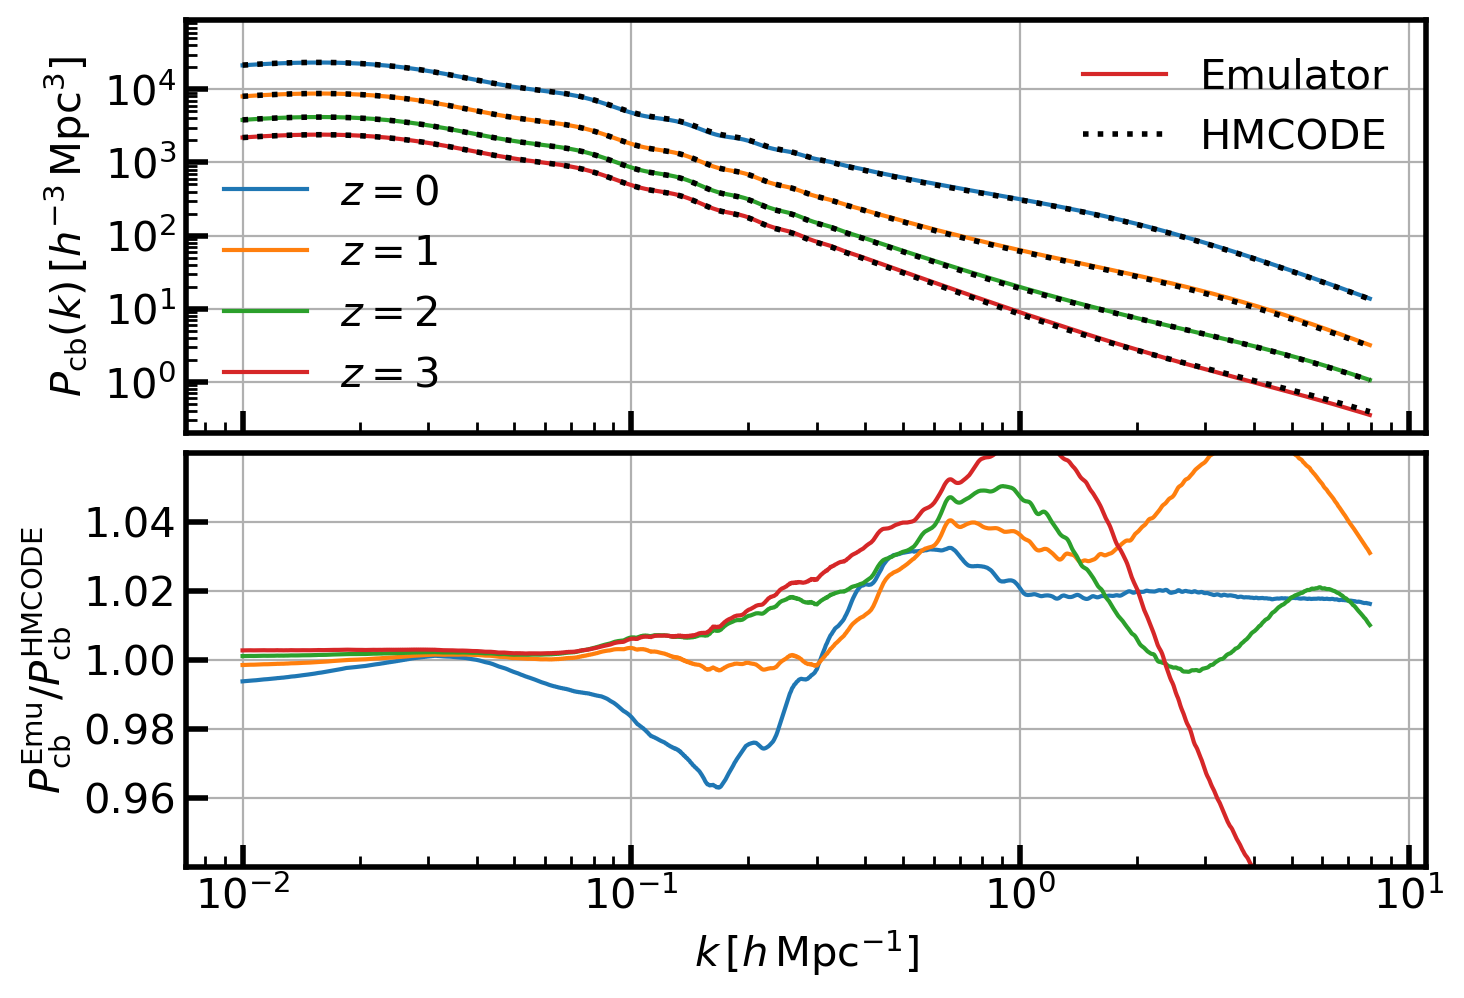

In [11]:
gridp = plt.GridSpec(2, 1, hspace=0.05)
with plt.style.context('article'):
    ax0 = plt.subplot(gridp[0,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkcbce[iz], label=r'$z=%.0f$'%(zlists[iz]))
        l2, = plt.plot(klists, pkcbhm[iz], 'k:', lw=2.0)
    leg1 = plt.legend([l1, l2], ['Emulator', 'HMCODE'], loc=0, frameon=False)
    leg2 = plt.legend(loc=3, frameon=False)
    ax0.add_artist(leg1)
    plt.grid(True)
    plt.ylabel(r'$P_{\rm cb}(k)\, [h^{-3}\,{\rm Mpc}^3]$')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(2e-1, 9e4)
    ax0.set_xticklabels([])
    ax1 = plt.subplot(gridp[1,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkcbce[iz]/pkcbhm[iz], label=r'$z=%.0f$'%(zlists[iz]))
    plt.ylabel(r'$P_{\rm cb}^{\rm Emu}/P_{\rm cb}^{\rm HMCODE}$')
    plt.xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
    plt.xscale('log')
    plt.ylim(0.9401, 1.0599)
    plt.grid(True)

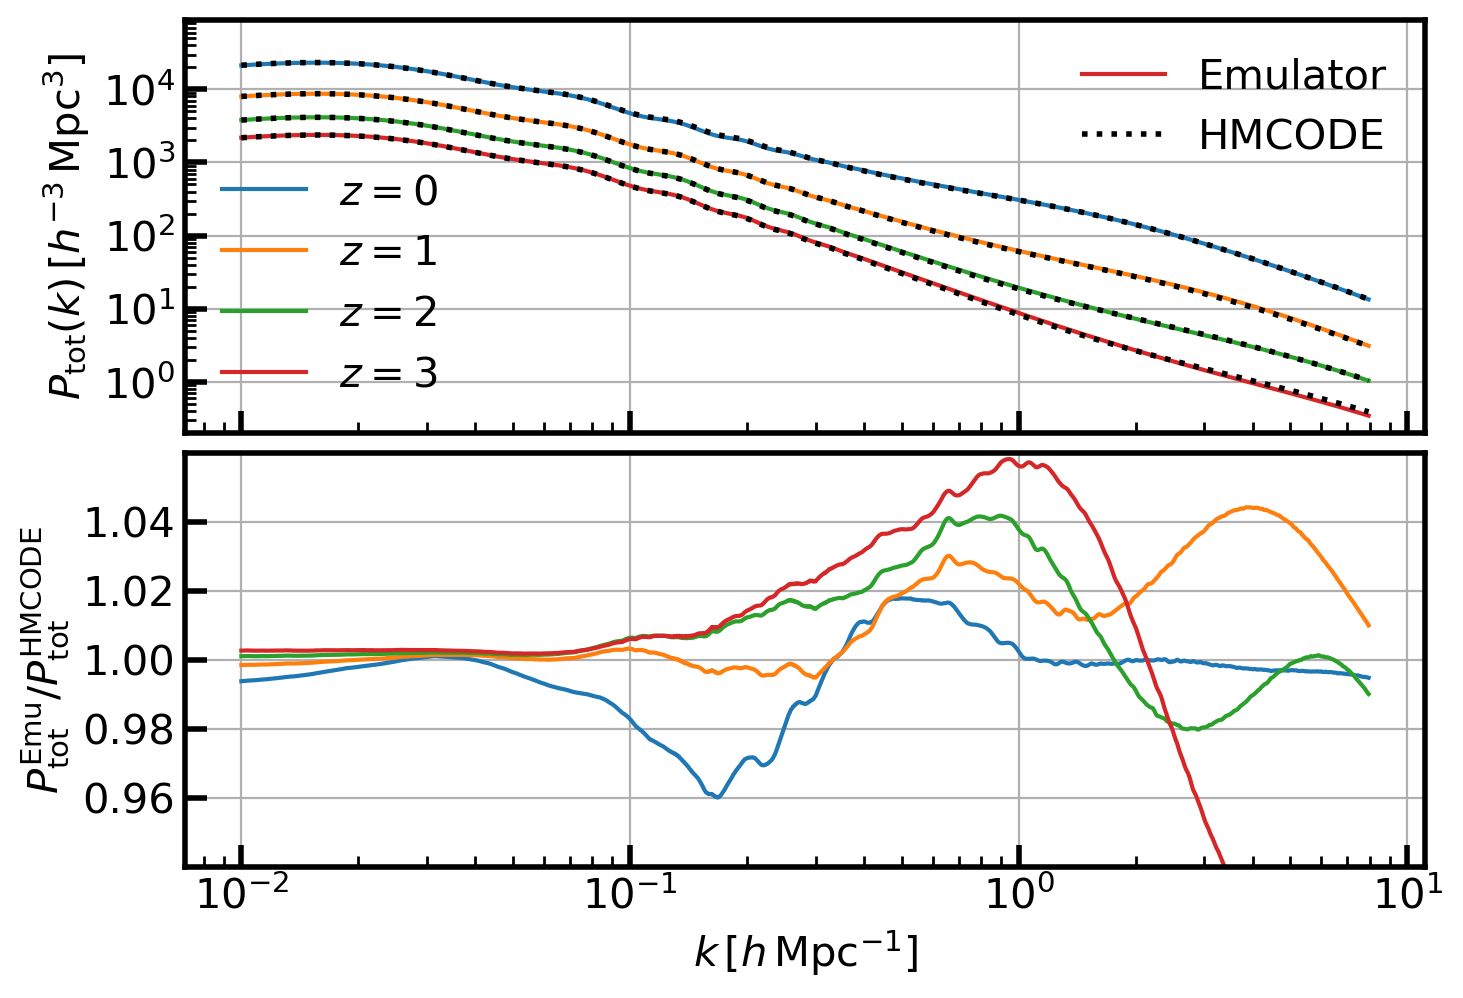

In [12]:
gridp = plt.GridSpec(2, 1, hspace=0.05)
with plt.style.context('article'):
    ax0 = plt.subplot(gridp[0,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkmmce[iz], label=r'$z=%.0f$'%(zlists[iz]))
        l2, = plt.plot(klists, pkmmhm[iz], 'k:', lw=2.0)
    leg1 = plt.legend([l1, l2], ['Emulator', 'HMCODE'], loc=0, frameon=False)
    leg2 = plt.legend(loc=3, frameon=False)
    ax0.add_artist(leg1)
    plt.grid(True)
    plt.ylabel(r'$P_{\rm tot}(k)\, [h^{-3}\,{\rm Mpc}^3]$')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(2e-1, 9e4)
    ax0.set_xticklabels([])
    ax1 = plt.subplot(gridp[1,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkmmce[iz]/pkmmhm[iz], label=r'$z=%.0f$'%(zlists[iz]))
    plt.ylabel(r'$P_{\rm tot}^{\rm Emu}/P_{\rm tot}^{\rm HMCODE}$')
    plt.xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
    plt.xscale('log')
    plt.ylim(0.9401, 1.0599)
    plt.grid(True)

## match $\sigma_8$

In [13]:
%%time
csstemu.set_cosmos(As=None, sigma8=0.73, sigma8type='CAMB')
As_camb = csstemu.Cosmo.As

The As is set to 1.714500e-09 (sigma8=0.730000) to match the input sigma8=0.730000.
CPU times: user 12.9 s, sys: 14.6 ms, total: 12.9 s
Wall time: 1.65 s


In [14]:
%%time
csstemu.set_cosmos(As=None, sigma8=0.73, sigma8type='CLASS')
As_class = csstemu.Cosmo.As

The As is set to 1.715719e-09 (sigma8=0.730000) to match the input sigma8=0.730000.
CPU times: user 8.14 s, sys: 28.8 ms, total: 8.17 s
Wall time: 1.51 s


In [15]:
%%time
csstemu.set_cosmos(As=None, sigma8=0.73, sigma8type='Emulator')
As_emu = csstemu.Cosmo.As

The As is set to 1.715915e-09 (sigma8=0.729921) to match the input sigma8=0.730000.
CPU times: user 12.7 ms, sys: 2 ms, total: 14.7 ms
Wall time: 14.3 ms


In [16]:
print('CAMB/CLASS:', As_camb/As_class)
print('Emu/CLASS :', As_emu/As_class)

CAMB/CLASS: 0.9992894916805883
Emu/CLASS : 1.0001144411728595


The agreement of $\sigma_8$ among Emulator CLASS and CAMB is less than 0.2% for cosmology in our emulation space.

In [17]:
pkcbce = csstemu.get_pknl(z=zlists, k=klists, 
                          Pcb=True, lintype='Emulator', 
                          nltype='halofit')
pkmmce = csstemu.get_pknl(z=zlists, k=klists, 
                           Pcb=False, lintype='Emulator', 
                           nltype='halofit')

cosmo_class = csstemu.get_cosmo_class(z=zlists, kmax=10.0, non_linear='HMCODE')
pkcbhm  = np.zeros((len(zlists), len(klists)))
pkmmhm = np.zeros((len(zlists), len(klists)))
h0 = csstemu.Cosmo.h0
for iz in range(len(zlists)):
    pkcbhm [iz] = np.array([cosmo_class.pk_cb(z=zlists[iz], k=ik*h0)*h0*h0*h0 for ik in klists])
    pkmmhm[iz] = np.array([cosmo_class.pk(z=zlists[iz], k=ik*h0)*h0*h0*h0 for ik in klists])


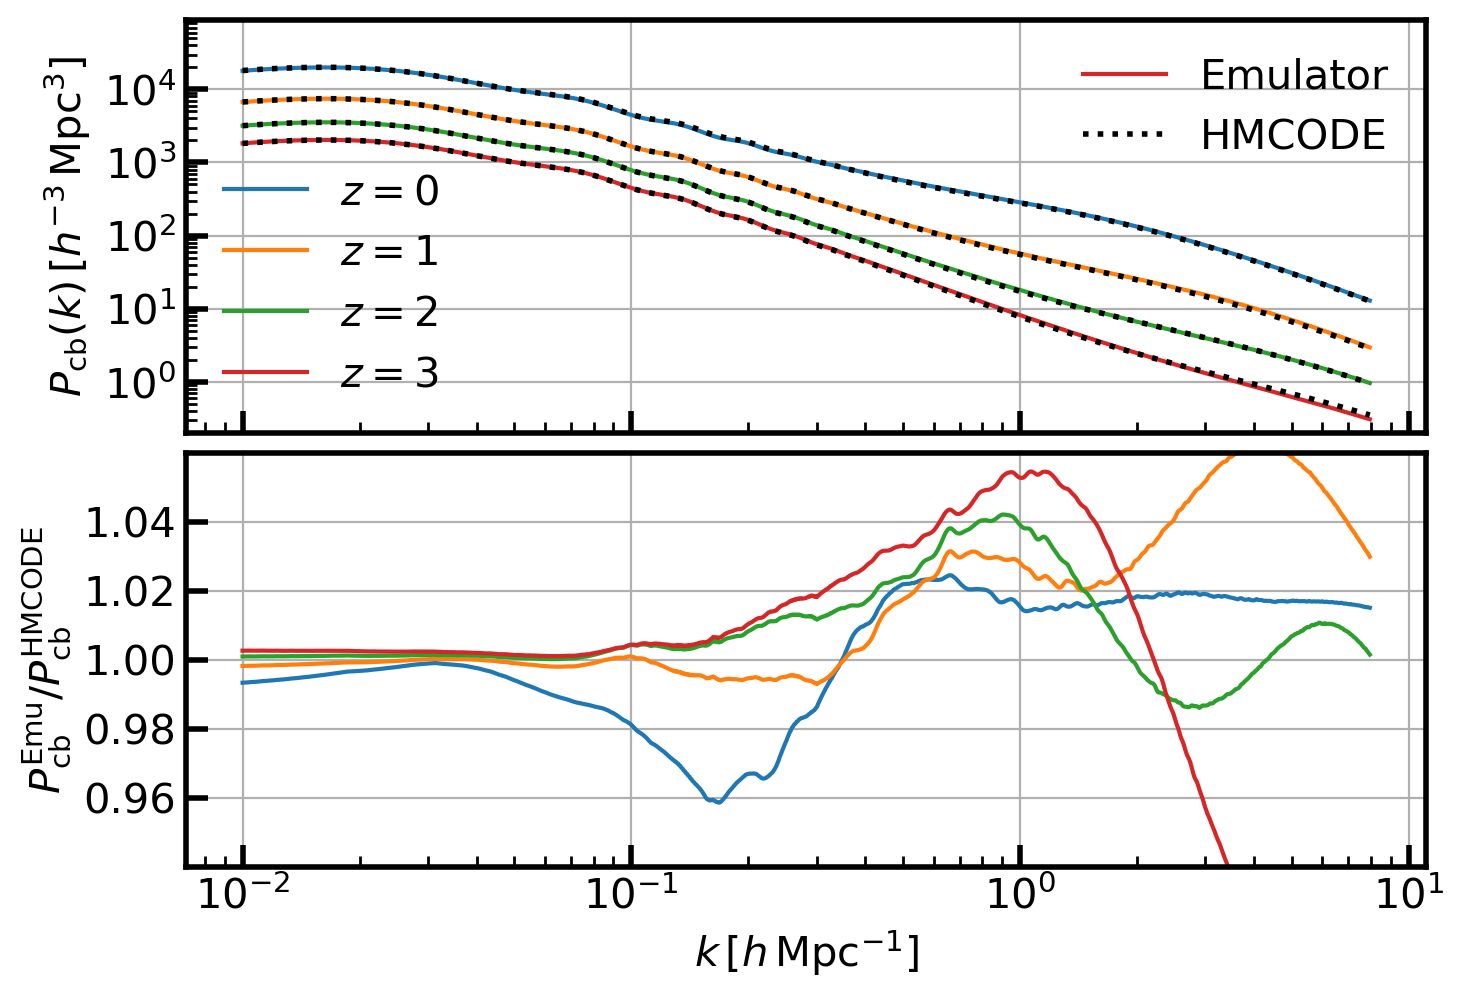

In [18]:
gridp = plt.GridSpec(2, 1, hspace=0.05)
with plt.style.context('article'):
    ax0 = plt.subplot(gridp[0,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkcbce[iz], label=r'$z=%.0f$'%(zlists[iz]))
        l2, = plt.plot(klists, pkcbhm[iz], 'k:', lw=2.0)
    leg1 = plt.legend([l1, l2], ['Emulator', 'HMCODE'], loc=0, frameon=False)
    leg2 = plt.legend(loc=3, frameon=False)
    ax0.add_artist(leg1)
    plt.grid(True)
    plt.ylabel(r'$P_{\rm cb}(k)\, [h^{-3}\,{\rm Mpc}^3]$')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(2e-1, 9e4)
    ax0.set_xticklabels([])
    ax1 = plt.subplot(gridp[1,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkcbce[iz]/pkcbhm[iz], label=r'$z=%.0f$'%(zlists[iz]))
    plt.ylabel(r'$P_{\rm cb}^{\rm Emu}/P_{\rm cb}^{\rm HMCODE}$')
    plt.xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
    plt.xscale('log')
    plt.ylim(0.9401, 1.0599)
    plt.grid(True)

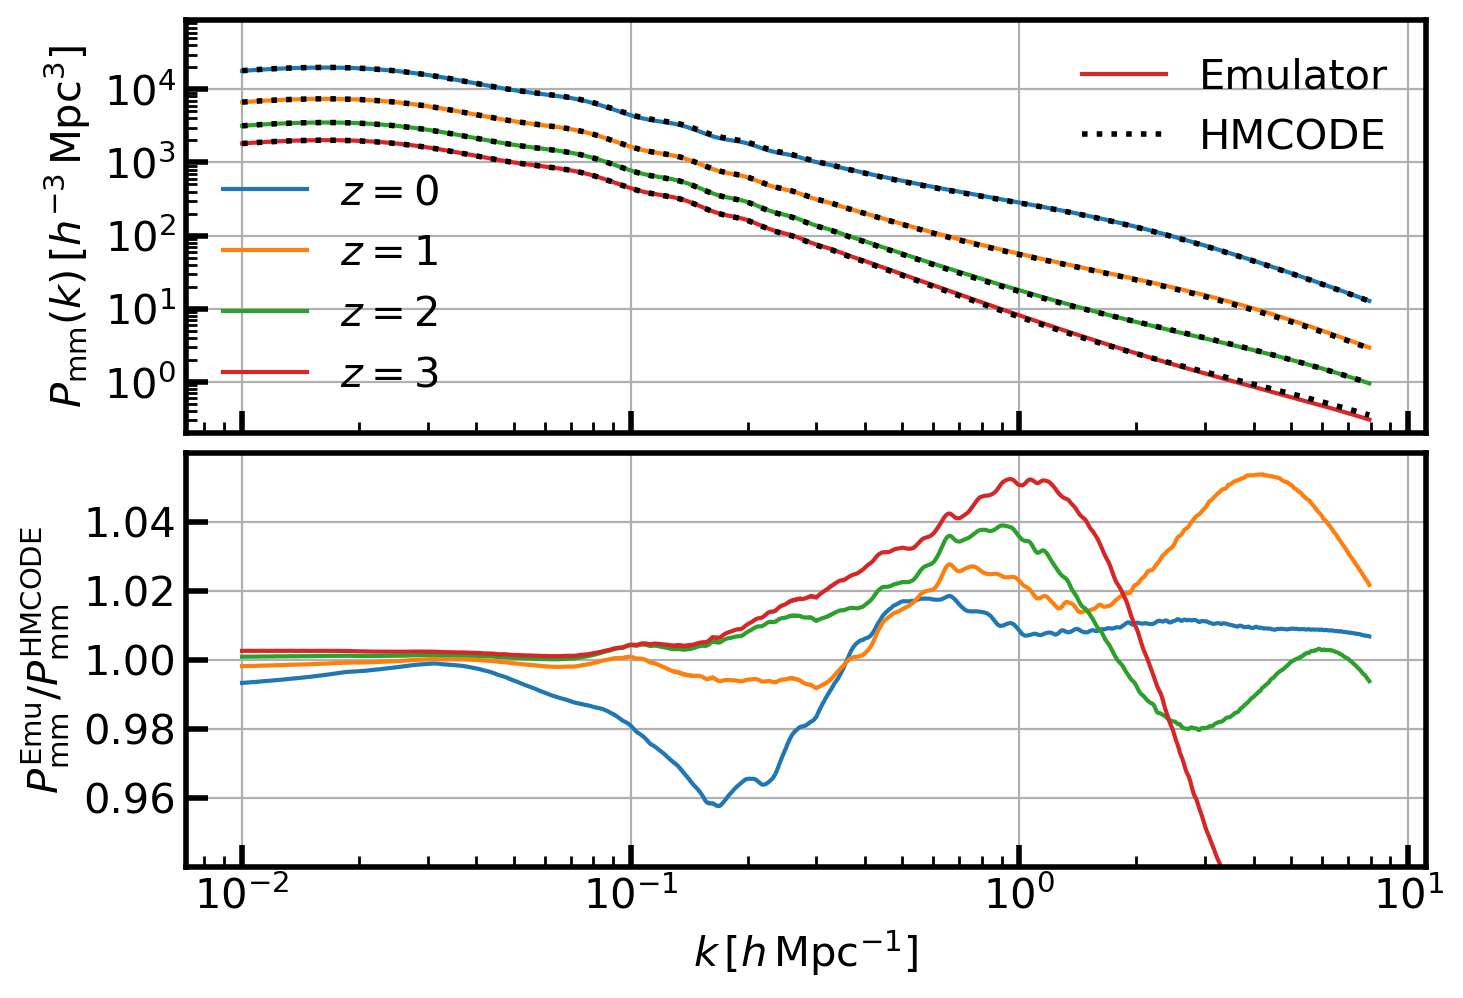

In [19]:
gridp = plt.GridSpec(2, 1, hspace=0.05)
with plt.style.context('article'):
    ax0 = plt.subplot(gridp[0,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkmmce[iz], label=r'$z=%.0f$'%(zlists[iz]))
        l2, = plt.plot(klists, pkmmhm[iz], 'k:', lw=2.0)
    leg1 = plt.legend([l1, l2], ['Emulator', 'HMCODE'], loc=0, frameon=False)
    leg2 = plt.legend(loc=3, frameon=False)
    ax0.add_artist(leg1)
    plt.grid(True)
    plt.ylabel(r'$P_{\rm mm}(k)\, [h^{-3}\,{\rm Mpc}^3]$')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(2e-1, 9e4)
    ax0.set_xticklabels([])
    ax1 = plt.subplot(gridp[1,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkmmce[iz]/pkmmhm[iz], label=r'$z=%.0f$'%(zlists[iz]))
    plt.ylabel(r'$P_{\rm mm}^{\rm Emu}/P_{\rm mm}^{\rm HMCODE}$')
    plt.xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
    plt.xscale('log')
    plt.ylim(0.9401, 1.0599)
    plt.grid(True)

In [20]:
csstemu.set_cosmos(As=None, sigma8=0.73, sigma8type='CAMB')

camb_results = csstemu.get_camb_results(z=zlists, kmax=10.0, non_linear='mead2020')
pkfunc = camb_results.get_matter_power_interpolator(nonlinear=True,
                                                    hubble_units=True, k_hunit=True,
                                                    var1='delta_nonu', var2='delta_nonu')
pkcbhm20 = pkfunc.P(zlists, klists)   
pkfunc = camb_results.get_matter_power_interpolator(nonlinear=True,
                                                    hubble_units=True, k_hunit=True,
                                                    var1='delta_tot', var2='delta_tot')
pkmmhm20 = pkfunc.P(zlists, klists)

The As is set to 1.714500e-09 (sigma8=0.730000) to match the input sigma8=0.730000.


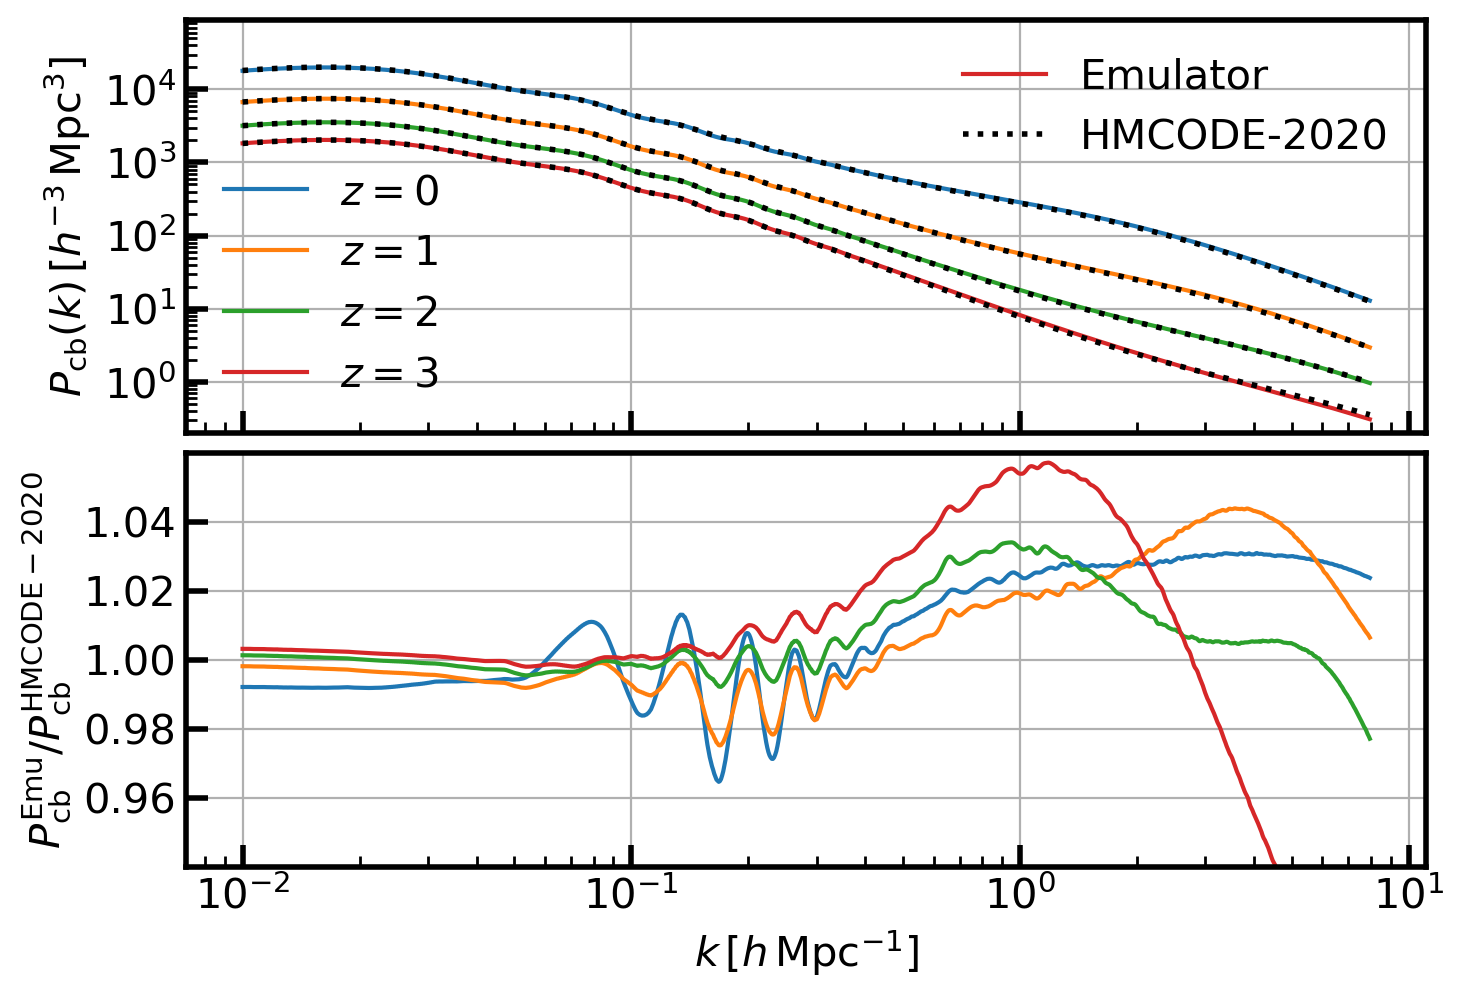

In [21]:
gridp = plt.GridSpec(2, 1, hspace=0.05)
with plt.style.context('article'):
    ax0 = plt.subplot(gridp[0,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkcbce[iz], label=r'$z=%.0f$'%(zlists[iz]))
        l2, = plt.plot(klists, pkcbhm20[iz], 'k:', lw=2.0)
    leg1 = plt.legend([l1, l2], ['Emulator', 'HMCODE-2020'], loc=0, frameon=False)
    leg2 = plt.legend(loc=3, frameon=False)
    ax0.add_artist(leg1)
    plt.grid(True)
    plt.ylabel(r'$P_{\rm cb}(k)\, [h^{-3}\,{\rm Mpc}^3]$')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(2e-1, 9e4)
    ax0.set_xticklabels([])
    ax1 = plt.subplot(gridp[1,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkcbce[iz]/pkcbhm20[iz], label=r'$z=%.0f$'%(zlists[iz]))
    plt.ylabel(r'$P_{\rm cb}^{\rm Emu}/P_{\rm cb}^{\rm HMCODE-2020}$')
    plt.xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
    plt.xscale('log')
    plt.ylim(0.9401, 1.0599)
    plt.grid(True)

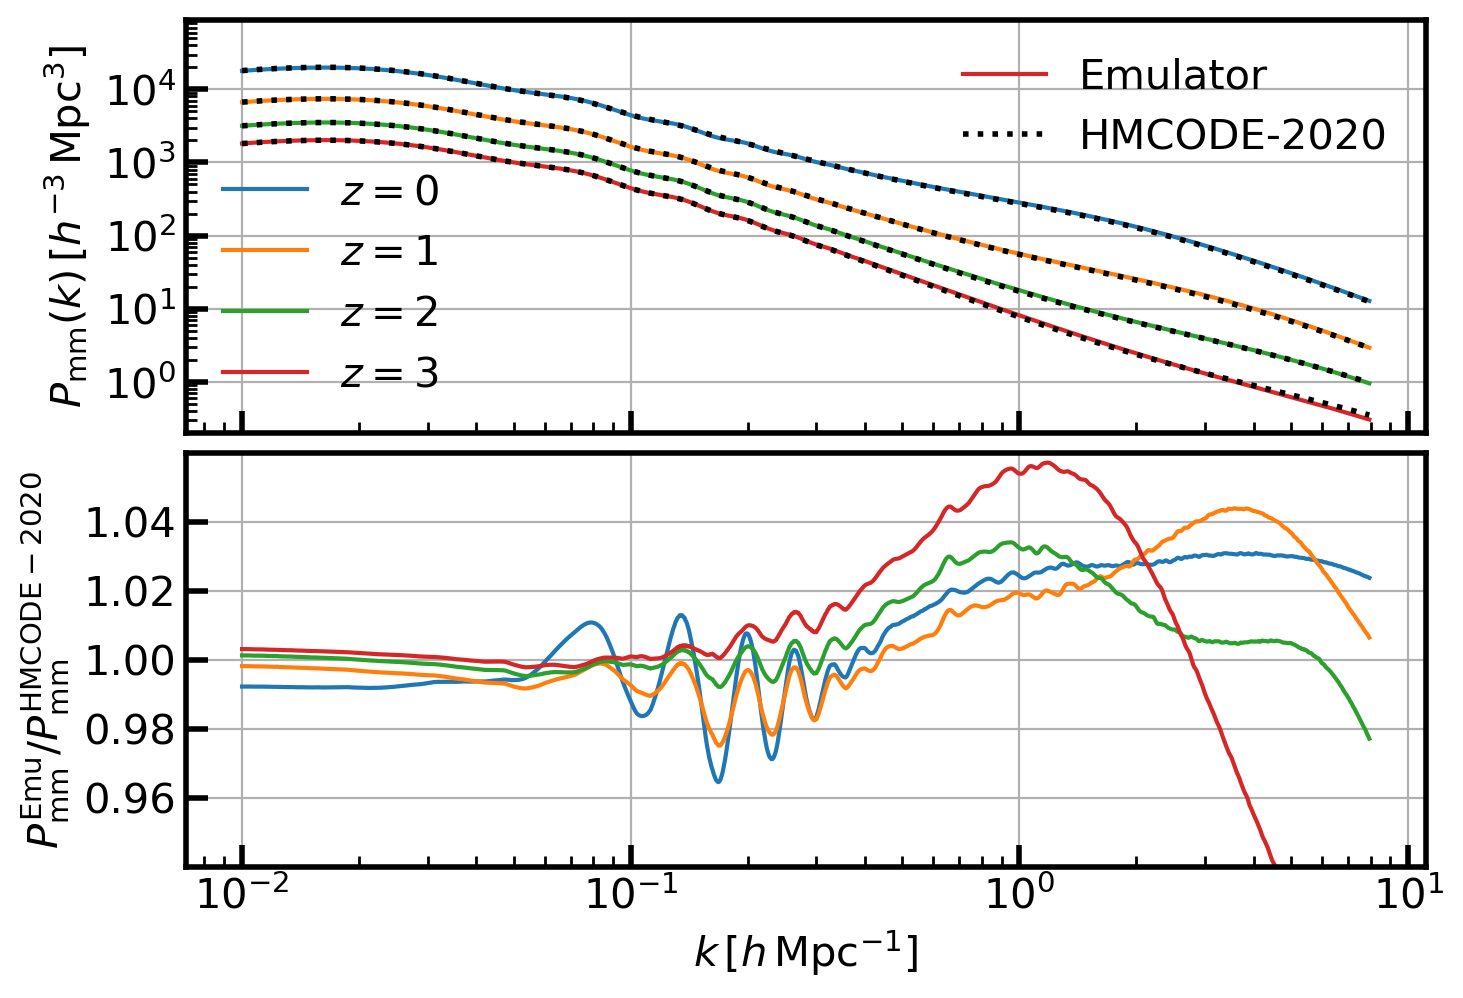

In [22]:
gridp = plt.GridSpec(2, 1, hspace=0.05)
with plt.style.context('article'):
    ax0 = plt.subplot(gridp[0,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkmmce[iz], label=r'$z=%.0f$'%(zlists[iz]))
        l2, = plt.plot(klists, pkmmhm20[iz], 'k:', lw=2.0)
    leg1 = plt.legend([l1, l2], ['Emulator', 'HMCODE-2020'], loc=0, frameon=False)
    leg2 = plt.legend(loc=3, frameon=False)
    ax0.add_artist(leg1)
    plt.grid(True)
    plt.ylabel(r'$P_{\rm mm}(k)\, [h^{-3}\,{\rm Mpc}^3]$')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(2e-1, 9e4)
    ax0.set_xticklabels([])
    ax1 = plt.subplot(gridp[1,0])
    for iz in range(len(zlists)):
        l1, = plt.plot(klists, pkmmce[iz]/pkmmhm20[iz], label=r'$z=%.0f$'%(zlists[iz]))
    plt.ylabel(r'$P_{\rm mm}^{\rm Emu}/P_{\rm mm}^{\rm HMCODE-2020}$')
    plt.xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
    plt.xscale('log')
    plt.ylim(0.9401, 1.0599)
    plt.grid(True)